In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
from keras.layers import Input, Dense, BatchNormalization, Dropout
from keras.models import Model

import gc, sys
gc.enable()

In [3]:
#load Dataset
df = pd.read_csv('/Users/User/Desktop/PUBG_match_data.csv')

In [4]:
def feature_engineering(df, is_train=True):
    # fix rank points
    df['rankPoints'] = np.where(df['rankPoints'] <= 0, 0, df['rankPoints'])
    
    print('adding new features...')
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    df['headshotrate'] = df['kills'] / df['headshotKills']
    df['killStreakrate'] = df['killStreaks'] / df['kills']
    df['healthitems'] = df['heals'] + df['boosts']
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['distance_over_weapons'] = df['totalDistance'] / df['weaponsAcquired']
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['killsPerWalkDistance'] = df['kills'] / df['walkDistance']
    df["skill"] = df["headshotKills"]+df["roadKills"]
    
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    
    print("Removing Na's From DF")
    df.fillna(0, inplace=True)
    
    print(df.isnull().any().any())
    
    target = 'winPlacePerc'
    features = list(df.columns)
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchType")
    
    y = None
    if is_train: 
        y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
        features.remove(target)
    
    print("adding group mean feature...")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()    
    if is_train: 
        df_out = agg.reset_index()[['matchId','groupId']]
    else: 
        df_out = df[['matchId','groupId']]
        df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
        df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    print("adding group max feature...")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    print("adding group min feature...")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    print("adding group size feature...")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    print("adding match mean feature...")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    print("adding match size feature...")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    del df, agg, agg_rank
    gc.collect()
    
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)

    df_out = np.array(df_out, dtype=np.float64)

    return df_out, y

In [5]:
train_X, train_y = feature_engineering(df, True)

adding new features...
Removing Na's From DF
False
adding group mean feature...
adding group max feature...
adding group min feature...
adding group size feature...
adding match mean feature...
adding match size feature...


In [6]:
#Standard_Scaler
scaler = StandardScaler().fit(train_X)
train_X = scaler.transform(train_X)

In [7]:
#Train_test_split dataset
# target = 'winPlacePerc'
# drop_col = ['winPlacePerc','Id','groupId','matchId','matchType']
# y = df[target]
# X = df.drop(columns = drop_col)
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2, shuffle = True)

In [8]:
def get_model(input_size):
    input_X = Input((input_size, ))
    X = layers.Dense(64, activation = 'sigmoid')(input_X)
    X = layers.Dropout(0.5)(X)
    X = layers.Dense(64, activation = 'sigmoid')(X)
    output = layers.Dense(1, activation = 'sigmoid')(X)
    
    model = Model(inputs = input_X, outputs = output)
    
    return model

In [9]:
input_size = train_X.shape[1]

In [10]:
m1 = get_model(input_size)

In [11]:
m1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 177)]             0         
                                                                 
 dense (Dense)               (None, 64)                11392     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,617
Trainable params: 15,617
Non-trainable params: 0
_________________________________________________________________


In [12]:
opt = optimizers.Adam(learning_rate = 0.01, epsilon = 1e-8, amsgrad = False)
m1.compile(optimizer = opt, loss='mean_absolute_error', metrics=['mae'])

In [13]:
history = m1.fit(train_X, train_y, batch_size = 2048, epochs = 50, validation_data = (test_X, test_y), verbose = 1)

Epoch 1/50
792/792 [==============================] - 2s 3ms/step - loss: 0.0548 - mae: 0.0548 - val_loss: 0.0367 - val_mae: 0.0367
Epoch 2/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.0363 - val_mae: 0.0363
Epoch 3/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0382 - mae: 0.0382 - val_loss: 0.0351 - val_mae: 0.0351
Epoch 4/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0371 - mae: 0.0371 - val_loss: 0.0377 - val_mae: 0.0377
Epoch 5/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0363 - mae: 0.0363 - val_loss: 0.0412 - val_mae: 0.0412
Epoch 6/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0358 - mae: 0.0358 - val_loss: 0.0396 - val_mae: 0.0396
Epoch 7/50
792/792 [==============================] - 2s 2ms/step - loss: 0.0353 - mae: 0.0353 - val_loss: 0.0418 - val_mae: 0.0418
Epoch 8/50
792/792 [==============================] - 2s 2ms/step - loss: 0.

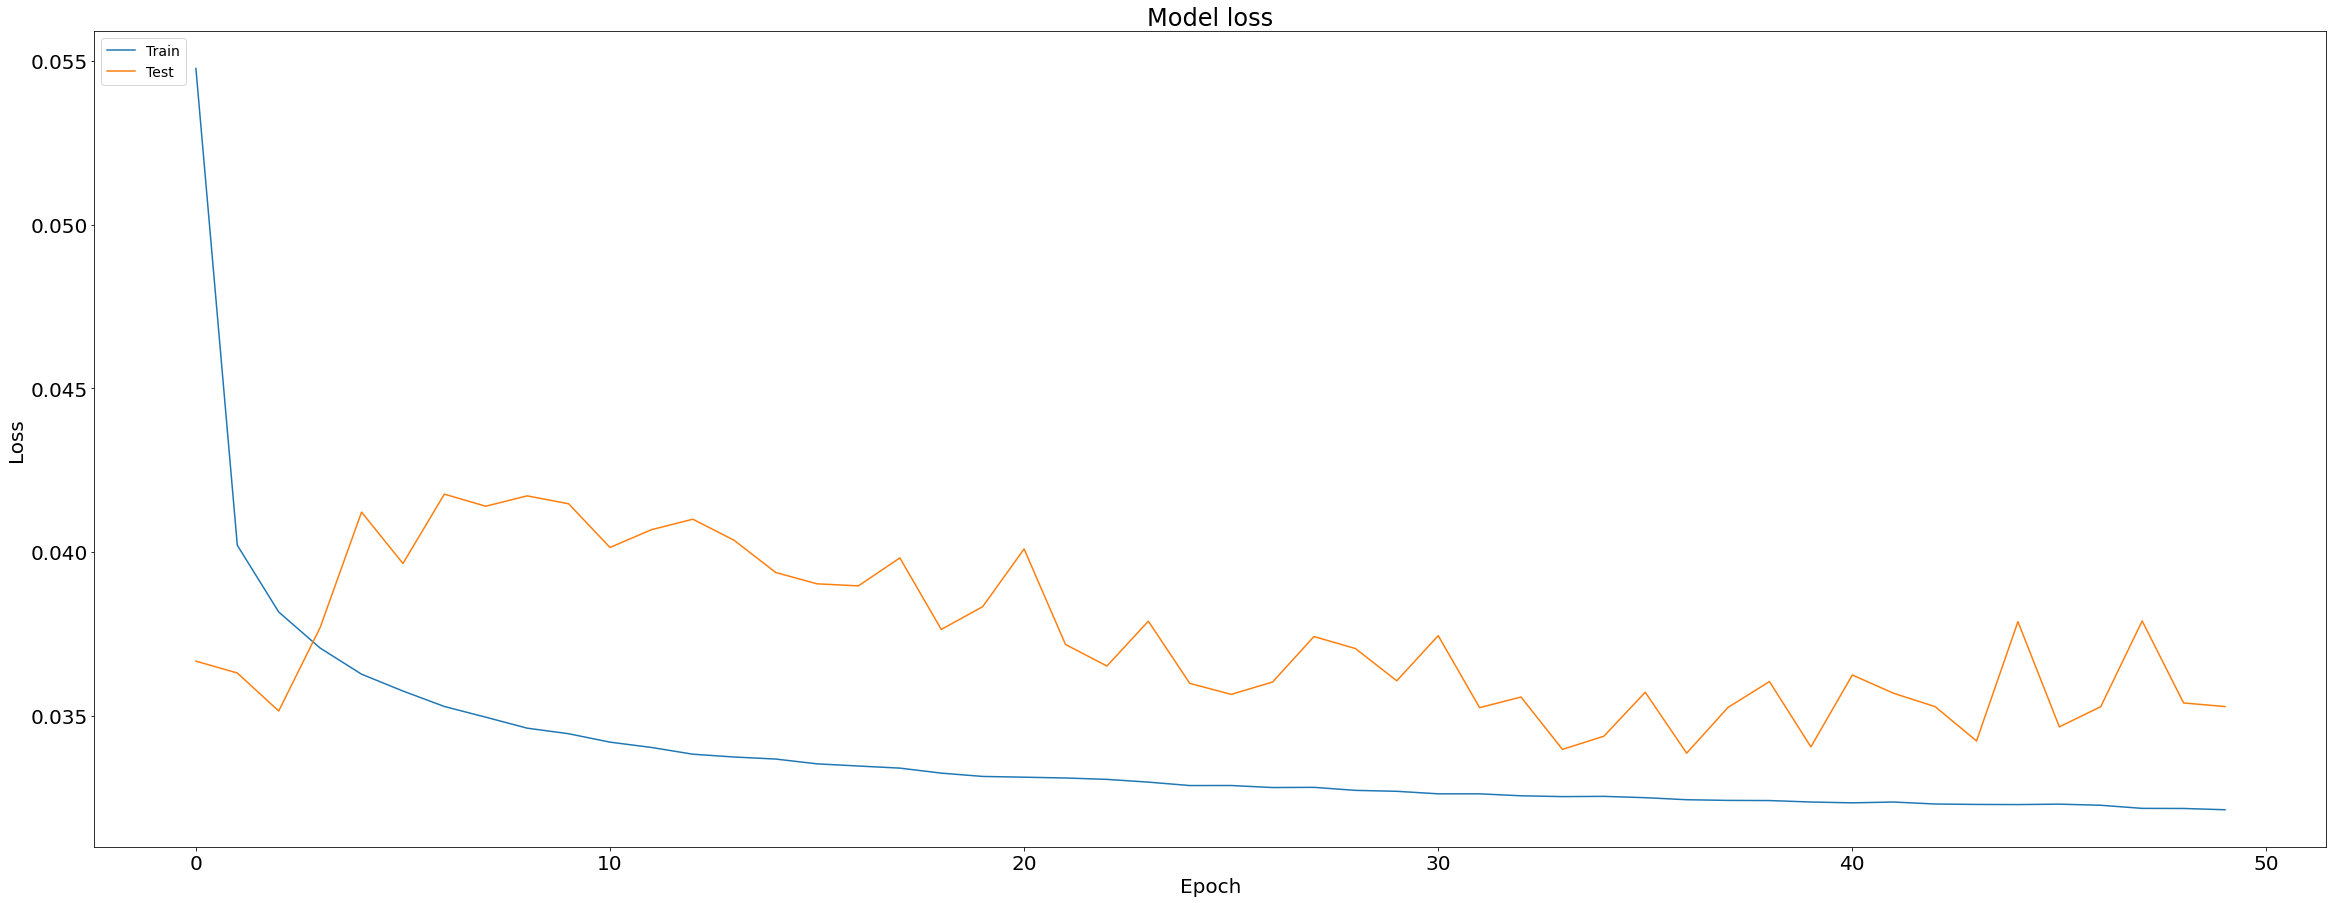

In [15]:
plt.figure(figsize = (40,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.rcParams['font.size'] = '20'
plt.legend(['Train', 'Test'], loc='upper left', fontsize = 14)
plt.show()